#Abstract

In [previous observations](https://github.com/kevinhhl/options-pricing-tools-and-trading-strategies/blob/main/Sensitivity_Analysis_Changes_in_Spot_and_Sigma.ipynb), we noticed that the market values of near-the-money options are often overpriced when compared to theoretical values computed by the Black Scholes model. In many instances, buying an at-the-money straddle (ATM Straddle) is not a good idea because if the price sits still before the option contracts expire, then the buyer loses to time decay. 

Subscribing to the notion that most ATM Straddles are overpriced, then we should be selling calls and puts instead. 

Going with this proposition, we should sell a strangle by following these steps:

* **Step 1**: Check that ATM Straddle has a negative theoretical edge, and 

* **Step 2**: Determine a reasonable range of where the price will likely sit on or before the date of expiration. 

* **Step 3**: Model a strangle according to the price interval (as identified in step 2), and check whether the model gives a positive theoretical edge.




# Implementations (can skip to Application section) 



In [ ]:
!pip install yahoo_fin
from yahoo_fin import options

!pip install yfinance
import yfinance as yf

import time
import pandas as pd
from scipy.stats import norm

import math
from datetime import date

import seaborn as sb
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import numpy as np

#### class BSM():

In [ ]:
class BSM:
  
  def __init__(self, x, s,t,r,sigma):
    self.d1, self.d2 = None, None
    self.tv_call, self.delta_call , self.gamma_call, self.vega_call, self.theta_call, self.rho_call = None, None, None, None, None, None
    self.tv_put, self.delta_put, self.gamma_put, self.vega_put, self.theta_put, self.rho_put = None, None, None, None, None, None

    self.x = x
    self.s = s
    self.t = t
    self.r = r
    self.sigma = sigma
    self.calc()

  def calc(self):
    ''' Calculates all the theoretical and Greeks values for call and put. 
        Need to call calc() whenever new input is provided. 
    '''
    _a = math.log(self.s/ self.x)
    _b = (self.r+self.sigma**2/2)*self.t
    self.d1 = (_a+_b)/self.sigma*math.sqrt(self.t)
    self.d2 = self.d1 - self.sigma * math.sqrt(self.t)
    
    # Call: 
    self.tv_call    = self.s * norm.cdf(self.d1) - self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2)
    self.delta_call = norm.cdf(self.d1)
    self.gamma_call = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_call  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_call = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) - self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    self.rho_call   = 0.01*(self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    
    # Put: 
    self.tv_put    = self.x * math.exp(-self.r*self.t)-self.s+self.tv_call
    self.delta_put = -norm.cdf(-self.d1)
    self.gamma_put = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_put  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_put = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) + self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(-self.d2))
    self.rho_put   = 0.01*(-self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(-self.d2))



#### class contract():

In [ ]:
class contract:

  def __init__(self, expiry_date, strike, contracttype, quoted_price):
    self.multiple = 100
    self.strike = strike
    self.contracttype=contracttype
    self.expiry_date = expiry_date
    self.price = quoted_price

  def __str__(self):
    return "{}_{}_{} @{}".format(self.expiry_date, self.strike, self.contracttype, self.price)

#### class leg():

In [ ]:
class leg:

  def __init__(self, side, contract, size, date_today, s,r,sigma):
    self.size=size
    leg.size = size
    self.side = side
    t = (contract.expiry_date-date_today).days/365
    self.contract = contract
    self.model = BSM(contract.strike, s,t,r,sigma)

    self.delta = None
    self.rho = None
    self.vega = None
    self.theta = None   
    self.gamma = None
    self.edge = 0
    self.premium = 0

    # int _coefficient, has three purposes:
    #   (1) +/-ve Delta for long call/put, but it's reversed from seller's perspective  
    #   (2) If buyer of contract:   +ve vega, -ve theta, +ve gamma
    #   (3) If seller of contract:  -ve vega, +ve theta, -ve gamma
    _coefficient = None
    if self.side == "long":
      _coefficient = 1
    elif self.side == "short":
      _coefficient = -1
    
    if contract.contracttype=="call":
      if self.side == "long":
        self.edge = (self.model.tv_call-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_call) * size 
      self.delta = self.model.delta_call * size  * _coefficient
      self.rho = self.model.rho_call * size      * _coefficient
      self.vega = self.model.vega_call * size    * _coefficient
      self.gamma = self.model.gamma_call * size  * _coefficient
      self.theta = self.model.theta_call * size  * _coefficient
    
    elif contract.contracttype=="put":
      if self.side == "long":
        self.edge = (self.model.tv_put-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_put) * size 
      self.delta = self.model.delta_put * size   * _coefficient
      self.rho = self.model.rho_put * size       * _coefficient
      self.vega = self.model.vega_put * size     * _coefficient
      self.gamma = self.model.gamma_put * size   * _coefficient
      self.theta = self.model.theta_put * size   * _coefficient
    
    self.premium = contract.price * size * -_coefficient

  def __str__(self):
    n_round= 4 
    return "{} [x{}]: Δ={},𝚪={},Θ={},V={},⍴={}".format(str(self.contract),self.size, \
      self.delta.round(n_round),self.gamma.round(n_round),self.theta.round(n_round),self.vega.round(n_round),self.rho.round(n_round))


###class position():

In [ ]:
class position:

  def __init__(self):
    self.list_leg = []
    
    self.total_delta = 0
    self.total_gamma = 0
    self.total_vega = 0
    self.total_theta = 0
    self.total_rho = 0
    self.total_premium = 0
    self.total_th_edge = 0

  def get_summary(self, rounding=4) -> dict:
    ''' Returns dict of {string:float}
    '''
    return {"Total delta" : round(self.total_delta,rounding),
            "Total gamma" : round(self.total_gamma,rounding),
            "Total vega"  : round(self.total_vega,rounding),
            "Total theta" : round(self.total_theta,rounding),
            "Total rho"   :round(self.total_rho,rounding),
            "Premium (paid)/received" : round(self.total_premium,rounding),
            "Th. Edge"    : round(self.total_th_edge,rounding),
            }
  
  def add_leg(self, leg):
    ''' @param leg
    '''
    size = leg.size
    self.total_premium += leg.premium
    self.total_th_edge += leg.edge
    self.list_leg.append(leg)
    
    self.total_delta += leg.delta
    self.total_gamma += leg.gamma
    self.total_vega += leg.vega
    self.total_theta += leg.theta
    self.total_rho += leg.rho 

  def plot_parity(self, midpoint, range_plusminus_midpoint):
    ''' For example: to plot 1 to 10:
        @param float midpoint, ie 5
        @param range range_plusminus_midpoint, ie range(-4,5)
        @returns a tuple of (list_x, list_y)
    '''
    xy = {}
      
    for leg in self.list_leg:
      
      # coefficient; if "long" then 1; if "short" then -1
      if leg.side == "short":
        _coeff = -1 * leg.size
      elif leg.side == "long":
        _coeff = 1 * leg.size

      for i in range_plusminus_midpoint:
        spot = i+midpoint
        if spot not in xy:
          xy[spot] = 0

        if leg.contract.contracttype == "call":
          xy[spot] = xy[spot] + max(0,spot-leg.contract.strike) * _coeff + leg.premium
        elif leg.contract.contracttype == "put":
          xy[spot] = xy[spot] + max(0,leg.contract.strike-spot) * _coeff + leg.premium

    list_x, list_y = [],[]
    for key in xy:
      list_x.append(key)
      list_y.append(xy[key])
    pd.DataFrame({"Spot":list_x, "Intrinsic Value":list_y } ).plot(x="Spot", y="Intrinsic Value")

    return (list_x, list_y)


###Helper functions for  sensitivity analysis

####Theoretical value vs Sigma

In [ ]:
def sensit_edge_v_sigma(initial_spot, initial_sigma, step_sigma, step_range_multiplier, clip=True):
  ''' @param float initial_spot
      @param float initial_sigma
      @param float step_sigma, in absolute amount
      @param float step_range_multiplier 
      @param bool clip, to clip off negative values
  '''
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _sigma = sigma + i*step_sigma
    tmp_pos = position() 

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=initial_spot, r=riskfree_rate, sigma=_sigma)
      tmp_pos.add_leg(_leg)

    _edge = tmp_pos.total_th_edge
    list_x.append(_sigma)
    if __tmp is not None and ((_edge > 0 and __tmp < 0) or (_edge < 0 and __tmp > 0)):
      list_zerocross.append(_sigma)
    __tmp = _edge
    list_y.append(_edge)

  df = pd.DataFrame({ "Sigma":list_x, "Theoretical Edge":list_y } )
  if clip:
    df = df[(df["Theoretical Edge"]>0) & (df["Sigma"]<1)] 
  print("X-intercepts (sigma): " + str(list_zerocross))
  df.plot(x="Sigma", y="Theoretical Edge");

####Delta vs Spot

In [ ]:
def sensit_delta_v_spot(initial_spot, step_spot, step_range_multiplier):
  ''' @param float initial_spot
      @param float step_spot, in absolute amount
      @param float step_range_multiplier 
      @param bool clip, to clip off negative values
      @Returns the approx spot price at where the position is delta neutral
  '''
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    _delta = tmp_pos.total_delta
    if __tmp is not None and (_delta > 0 and __tmp < 0 or _delta < 0 and __tmp > 0):
      list_zerocross.append(_spot)
    __tmp = _delta
    list_y.append(_delta)

  df = pd.DataFrame({ "Spot":list_x, "Delta":list_y } ) 
  print("Delta neutral crossing points: " + str(list_zerocross))
  df.plot(x="Spot", y="Delta");
  assert len(list_zerocross) == 1
  return list_zerocross[0]

###Misc

In [ ]:
def populate_dict(yf_chain, contracttype):
  ''' @param Object yf_chain : from options.get_options_chain(symbol, date_expire_str)["calls" or "puts"]
      @param string contracttype : either "call" or "put
      Returns a dict of {float strike price : contract object}
  '''
  out = {}
  for i in range(len(yf_chain)):
    x = yf_chain["Strike"][i]
    out[x] = contract(date_expire, x, contracttype, yf_chain["Last Price"][i])
  return out


In [ ]:
def _mcs_subtask1(price_data, verbose, n_iters=10000):
  # Print basic stats: mean, var., and drift
  price_data = price_data["Close"]
  pc = np.log(1+price_data.pct_change()) 

  if verbose:
    sb.histplot(pc.iloc[1:])
    plt.title("Historical Log Returns")
    plt.xlabel("Log Returns (Daily)")
    plt.ylabel("Frequency");

  mean = pc.mean()
  var = pc.var()
  stddev = pc.std()
  drift = mean - 0.5*var
  if verbose:
    print("mean={}, var={}, drift={}".format(mean, var, drift))

  # Determine how many periods to perform random walk:
  date_t0 = date_today
  date_tn = date_expire

  n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
  _t0 = date_t0         # tmp var.
  while _t0 <= date_tn:
    n_forecast += 1
    _t0 += BDay(1)

  # Init. array[n_forecast][n_iters] of zeros 
  rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
  sim_equity_curve = np.zeros_like(rand_returns)

  # Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
  sim_equity_curve[0] = price_data[len(price_data)-1]

  # Perform random walk and plot
  for t in range(1,n_forecast):
      sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]
  
  return (n_forecast,sim_equity_curve,rand_returns,date_t0,date_tn)

def perform_mcs(price_data, verbose=False):
  ''' @param price_data is a dataframe from ie. ticker_yahoo.history(period="3y") 
      @returns tuple of floats (lower bound, upper bound) of price at t_n
  '''
  n_forecast,sim_equity_curve,rand_returns,date_t0,date_tn = _mcs_subtask1(price_data, verbose) 

  assert(sim_equity_curve.shape==rand_returns.shape)
  print("\n{}\nShape={}".format(symbol, sim_equity_curve.shape))
  if verbose:
    print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn))) 

  plt.figure(figsize=(10,5))
  plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

  # Printing the reasonable ranges at every t+i 
  count = 0
  stdev_multi = 2

  for e in sim_equity_curve:
    std = e.std()
    mean = e.mean()
    lower_bound = (mean-stdev_multi*std).round(2)
    upper_bound = (mean+stdev_multi*std).round(2)
    if verbose:
      print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}".format(count, date_t0+BDay(count), std.round(2), mean.round(2), lower_bound, upper_bound))
    count += 1

  return (lower_bound, upper_bound)


#😎Application:  

In [ ]:
# 😎 Manual inputs:
symbol                   = "KO" 
sigma                    = 0.15
riskfree_rate            = math.e**(.0393)-1 
date_expire              = date(2023,3,17) 


In [ ]:
# Obtaining market data
data = yf.Ticker(symbol).history(period="1y")
crnt_price = data['Close'].iloc[-1] 
date_expire_str = date_expire.strftime("%B %d, %Y") 
exp_dates = options.get_expiration_dates(symbol) 
assert date_expire_str in exp_dates
calls = populate_dict(options.get_options_chain(symbol, date_expire_str)["calls"], "call")
puts = populate_dict(options.get_options_chain(symbol, date_expire_str)["puts"], "put")
date_today = data.index[len(data)-1]

print("{} @{} on {}".format(symbol, crnt_price.round(2), date_today.strftime("%B %d, %Y %H:%M") ))
print(exp_dates)
date_today = date(date_today.year, date_today.month, date_today.day)

KO @58.86 on March 01, 2023 00:00
['March 3, 2023', 'March 10, 2023', 'March 17, 2023', 'March 24, 2023', 'March 31, 2023', 'April 6, 2023', 'April 21, 2023', 'May 19, 2023', 'June 16, 2023', 'July 21, 2023', 'August 18, 2023', 'December 15, 2023', 'January 19, 2024', 'June 21, 2024', 'January 17, 2025']


#Step 1: Confirming that it's a bad idea to buy ATM Straddle


{'Total delta': 0.0189,
 'Total gamma': 0.4315,
 'Total vega': 0.0983,
 'Total theta': -0.168,
 'Total rho': -0.0002,
 'Premium (paid)/received': -1.91,
 'Th. Edge': -0.4411}

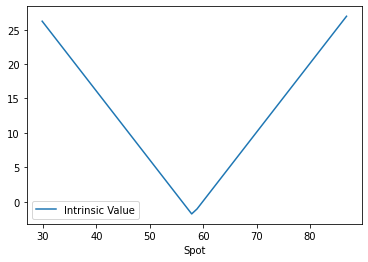

In [ ]:
# 😎 Manual inputs:
strike = 58
assert strike in calls
assert strike in puts

# 😎 Manual inputs:
legs = (\
leg(side="long", contract=puts[strike], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma), \
leg(side="long", contract=calls[strike], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma) \
)

pos = position()
for e in legs:
  pos.add_leg(e)

intrinsic_vals = pos.plot_parity(crnt_price, range(int(-crnt_price/2),int(crnt_price/2))) 
pos.get_summary()

In [ ]:
assert pos.total_th_edge  < 0

>We won't buy this straddle, instead we will go against the buyers of the spread by selling a **strangle**  

#Step 2: Determining a reasonable range

Historical lookback, n=251

KO
Shape=(13, 10000)


<ipython-input-9-3440a98bfa97>:25: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:


Expecting price of underlying asset
 to be in between 53.77 to 63.81 when options expire.


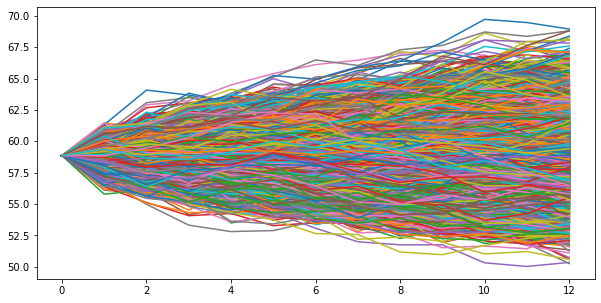

In [ ]:
print("Historical lookback, n="+str(len(data)))
mcs_lower, mcs_upper = perform_mcs(data)

print("Expecting price of underlying asset\n to be in between {} to {} when options expire.".format(mcs_lower, mcs_upper))

#Step 3: Constructing the strangle 

In [ ]:
lower_bound = int(mcs_lower)
upper_bound = int(mcs_upper)

assert lower_bound in puts 
assert upper_bound in calls
(lower_bound, upper_bound)

(53, 63)

{'Total delta': -0.0229,
 'Total gamma': -0.4283,
 'Total vega': -0.0976,
 'Total theta': 0.1687,
 'Total rho': -0.0019,
 'Premium (paid)/received': 0.09,
 'Th. Edge': 3.1399}

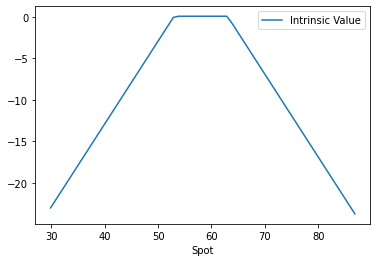

In [ ]:
legs = (\
leg(side="short", contract=puts[lower_bound], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma), \
leg(side="short", contract=calls[upper_bound], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma) \
)

pos = position()
for e in legs:
  pos.add_leg(e)

intrinsic_vals = pos.plot_parity(crnt_price, range(int(-crnt_price/2),int(crnt_price/2))) 

assert pos.total_th_edge  > 0
pos.get_summary()

In [ ]:
assert pos.total_vega < 0

X-intercepts (sigma): [0.52]


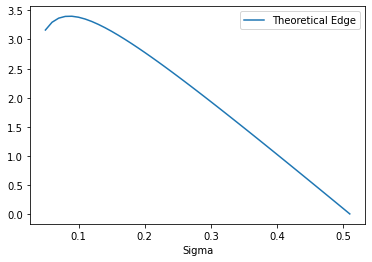

In [ ]:
sensit_edge_v_sigma(crnt_price, sigma, step_sigma=0.01, step_range_multiplier=range(-10,50))

Our vega is negative. As a strangle-seller, a violent move to either direction could hurt us.

As volatility (denoted as Sigma) falls, the higher probability that the counterparties (buyers of the options contract) will be holding onto worthless papers. As evil as it sounds, it's what we ultimately want. 

Delta neutral crossing points: [57.86000061035156]


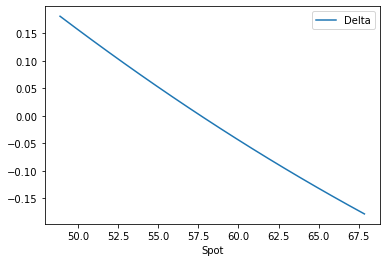

In [ ]:
spot_dn = sensit_delta_v_spot(crnt_price, step_spot=1, step_range_multiplier=range(-10,10))

In [ ]:
print("To become delta neutral, spot price needs to move by {} (from {} to {}). As usual, holding all other variables constant".format((spot_dn-crnt_price).round(2), crnt_price.round(2), spot_dn.round(2)))

To become delta neutral, spot price needs to move by -1.0 (from 58.86 to 57.86). As usual, holding all other variables constant
